<a href="https://colab.research.google.com/github/shreyanshtomar/moderation/blob/shreyansh_dev/server/notebooks/PyTorch/moderation_vgg16.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Getting the data...

Source: https://www.kaggle.com/omeret/nsfw-nsafe & https://www.kaggle.com/omeret/nsfw-safe.

The combined dataset contains: 
* Number training images:  103518
* Num test images:  3365

After getting the data...
##Importing Library and Data

To begin, import the torch and torchvision frameworks and their libraries with numpy, pandas, and sklearn. Libraries and functions used in the code below include:

* [transforms](https://pytorch.org/docs/stable/torchvision/transforms.html), for basic image transformation
* [torch.nn.functional](https://pytorch.org/docs/stable/nn.functional.html), which contains useful activation functions.
* [Dataset and Dataloader](https://pytorch.org/docs/0.3.0/torchvision/datasets.html), PyTorch's data loading utility 

---



In [ ]:
import copy
import cv2                
from glob import glob
from io import open
import json
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import os, os.path, random
from PIL import Image
import requests
import shutil
import time

import torch
from torch.autograd import Variable
import torch.functional as F
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torchvision
from torchvision import datasets, models, transforms

plt.ion()   # interactive mode

%matplotlib inline

Specifying the data directories.

In [ ]:
data_dir = '/content/'
train_dir = os.path.join(data_dir, 'train/')
test_dir = os.path.join(data_dir, 'test/')

# classes are folders in each directory with these names
classes = ['nsfw','sfw']

#Image Pre-processing

Images in a dataset do not usually have the same pixel intensity and dimensions.

You can stack multiple image transformation commands in [transform.Compose](https://pytorch.org/docs/master/torchvision/transforms.html#torchvision.transforms.Compose). Normalizing an image is an important step that makes model training stable and fast. In tranforms.Normalize() class, a list of means and standard deviations is sent in the form of a list. It uses this formula: ![alt text](https://i.imgur.com/pWSTFzG.png).
<br>
## Dataset Split

How well the model can learn depends on the variety and volume of the data. We need to divide our data into a training set and a validation set using PyTorch's [datasets.ImageFolder](https://pytorch.org/docs/master/torchvision/datasets.html?highlight=dataset%20image#torchvision.datasets.ImageFolder) utility since we already have downloaded the dataset in train_dir and test_dir directories.

**Training dataset**: The model learns from this dataset's examples. It fits a parameter to a classifier.

**Validation dataset**: The examples in the validation dataset are used to tune the hyperparameters, such as learning rate and epochs. The aim of creating a validation set is to avoid large overfitting of the model. It is a checkpoint to know if the model is fitted well with the training dataset.

Test dataset: This dataset test the final evolution of the model, measuring how well it has learned and predicted the desired output. It contains unseen, real-life data.



In [ ]:
train_transforms = transforms.Compose([
                            transforms.RandomResizedCrop(size=224),                                   
                            transforms.RandomHorizontalFlip(),
                            transforms.ToTensor(),
                            transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))])

test_transforms = transforms.Compose([                                  
                            transforms.Resize(256),
                            transforms.CenterCrop(224),
                            transforms.ToTensor(),
                            transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))])


train_data = datasets.ImageFolder(train_dir, transform=train_transforms)
test_data = datasets.ImageFolder(test_dir, transform=test_transforms)

# print out some data stats
print('Num training images: ', len(train_data))
print('Num test images: ', len(test_data))

Num training images:  103518
Num test images:  3365


Whenever you initialize the batch of images, it is on the CPU for computation by default. The function torch.cuda.is_available() will check whether a GPU is present. If CUDA is present, .device("cuda") will route the tensor to the GPU for computation.

The device will use CUDA with a single GPU processor. This will make our calculations faster. If you have a CPU in your system, no problem. You can use Google Colab, which provides free GPU.

In [ ]:
# check if CUDA is available
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...



In the code below, `dataloader` combines a dataset and a sampler and provides an iterable over the given dataset. `dataset()` indicates which dataset to load form the available data. For details, [read this documentation](https://pytorch.org/docs/stable/data.html#module-torch.utils.data).


In [ ]:
# define dataloader parameters
batch_size = 128
num_workers=0

# prepare data loaders
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, 
                                           num_workers=num_workers, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, 
                                          num_workers=num_workers, shuffle=True)
loaders_scratch = {
    'train': train_loader,
    'test': test_loader
}

# Visulazing the data..

Note: The output of data visualisation is hidden due to it's nature.

In [ ]:
#encoder and decoder to convert classes into integer
decoder = {}
for i in range(len(classes)):
    decoder[classes[i]] = i
encoder = {}
for i in range(len(classes)):
    encoder[i] = classes[i]

In [ ]:
inv_normalize =  transforms.Normalize(
    mean=[-0.4302/0.2361, -0.4575/0.2347, -0.4539/0.2432],
    std=[1/0.2361, 1/0.2347, 1/0.2432]
)

In [ ]:
import matplotlib.pyplot as plt
import random
#plotting rondom images from dataset
n_figures = 9 # Number of images in plot
def class_plot( data , encoder ,inv_normalizen_figures = 12):
    n_row = int(n_figures/3)
    fig,axes = plt.subplots(figsize=(14, 10), nrows = n_row, ncols=3)
    for ax in axes.flatten():
        a = random.randint(0,len(data))
        (image,label) = data[a]
        label = int(label)
        l = encoder[label]
        image = inv_normalize(image)
        image = image.numpy().transpose(1,2,0)
        im = ax.imshow(image)
        ax.set_title(l)
        ax.axis('off')
    plt.show()
class_plot(train_data,encoder,inv_normalize)

#Transfer Learning with Pytorch

The main aim of transfer learning (TL) is to implement a model quickly. To solve the current problem, instead of creating a DNN (dense neural network) from scratch, the model will transfer the features it has learned from the different dataset that has performed the same task. This transaction is also known as knowledge transfer.

<img src="https://i.imgur.com/3sx8Y3i.png" width = "600"/>

Why vgg-16?

VGG16 significantly outperforms the previous generation of models in the ILSVRC-2012 and ILSVRC-2013 competitions. The VGG16 result is also competing for the classification task winner (GoogLeNet with 6.7% error) and substantially outperforms the ILSVRC-2013 winning submission Clarifai, which achieved 11.2% with external training data and 11.7% without it. Concerning the single-net performance, VGG16 architecture achieves the best result (7.0% test error), outperforming a single GoogLeNet by 0.9%.

![alt text](https://neurohive.io/wp-content/uploads/2018/11/Capture-1-770x345.jpg)
[Source](https://neurohive.io/en/popular-networks/vgg16/)


The Pytorch API calls a pre-trained model of vgg-16 by using models.vgg16(pretrained=True), the function from TorchVision's model library. VGG-16 architecture is described below.

<img src="https://neurohive.io/wp-content/uploads/2018/11/vgg16-neural-network.jpg" width = "600"/>

In [ ]:
net = models.vgg16(pretrained=True)

In [ ]:
# Freeze training for all "features" layers
for param in net.features.parameters():
    param.requires_grad = False

In [ ]:
import torch.nn as nn

n_inputs = net.classifier[6].in_features

# add last linear layer
# new layers automatically have requires_grad = True
last_layer = nn.Linear(n_inputs, len(classes))

net.classifier[6] = last_layer

# if GPU is available, move the model to GPU
if train_on_gpu:
    net.cuda()

# check to see that your last layer produces the expected number of outputs
print(net.classifier[6].out_features)
#print(net)

# after completing your model, if GPU is available, move the model to GPU
if train_on_gpu:
    net.cuda()

2



## Specifying Loss & Optimizer:

Loss function and optimization go hand-in-hand. Loss function checks whether the model is moving in the correct direction and making progress, whereas optimization improves the model to deliver accurate results.
Select any one optimizer algorithm available in the [torch.optim](https://pytorch.org/docs/master/optim.html) package. The optimizers have some elements of the gradient descent.

Also, setting the hyperparameters below.

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# specify loss function (categorical cross-entropy)
criterion = nn.CrossEntropyLoss()

# specify optimizer (stochastic gradient descent) and learning rate = 0.001
optimizer = optim.SGD(net.classifier.parameters(), lr=0.001, momentum=0.9)

In [ ]:
n_epochs = 4
print_every = 10
valid_loss_min = np.Inf
val_loss = []
val_acc = []
train_loss = []
train_acc = []
total_step = len(train_loader)

    ###################
    # train the model #
    ###################

for epoch in range(1, n_epochs+1):
    running_loss = 0.0
    correct = 0
    total=0
    print(f'Epoch {epoch}\n')
    for batch_idx, (data_, target_) in enumerate(train_loader):
        data_, target_ = data_.to(device), target_.to(device)
        optimizer.zero_grad() # clear-the-gradients-of-all-optimized-variables
        outputs = net(data_) # forward-pass: compute-predicted-outputs-by-passing-inputs-to-the-model
        loss = criterion(outputs, target_) # calculate-the-batch-loss
        loss.backward() # backward-pass: compute-gradient-of-the-loss-wrt-model-parameters
        optimizer.step() # perform-a-ingle-optimization-step (parameter-update)

        running_loss += loss.item() # update-training-loss
        _,pred = torch.max(outputs, dim=1)
        correct += torch.sum(pred==target_).item()
        total += target_.size(0)
        if (batch_idx) % 20 == 0:
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                   .format(epoch, n_epochs, batch_idx, total_step, loss.item()))
    train_acc.append(100 * correct / total)
    train_loss.append(running_loss/total_step)
    print(f'\ntrain-loss: {np.mean(train_loss):.4f}, train-acc: {(100 * correct/total):.4f}')
    batch_loss = 0
    total_t=0
    correct_t=0

    ######################    
    # validate the model #
    ######################

    with torch.no_grad():
        net.eval()
        for data_t, target_t in (test_loader):
            data_t, target_t = data_t.to(device), target_t.to(device)
            outputs_t = net(data_t) # forward-pass: compute-predicted-outputs-by-passing-inputs-to-the-model
            loss_t = criterion(outputs_t, target_t) # calculate-the-batch-loss
            batch_loss += loss_t.item() # update-batch_loss
            _,pred_t = torch.max(outputs_t, dim=1)
            correct_t += torch.sum(pred_t==target_t).item()
            total_t += target_t.size(0)
        val_acc.append(100 * correct_t/total_t)
        val_loss.append(batch_loss/len(test_loader))
        network_learned = batch_loss < valid_loss_min
        print(f'validation loss: {np.mean(val_loss):.4f}, validation acc: {(100 * correct_t/total_t):.4f}\n')

        
        if network_learned:
            valid_loss_min = batch_loss
            torch.save(net.state_dict(), 'vgg16a.pt')
            print('Improvement-Detected, save-model')
    net.train()


In [ ]:
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, 
                                          num_workers=num_workers, shuffle=True)

In [ ]:
def test(loaders, model, criterion, train_on_gpu):

    # monitor test loss and accuracy
    test_loss = 0.
    correct = 0.
    total = 0.

    for batch_idx, (data, target) in enumerate(loaders['test']):
        # move to GPU
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the loss
        loss = criterion(output, target)
        # update average test loss 
        test_loss = test_loss + ((1 / (batch_idx + 1)) * (loss.data - test_loss))
        # convert output probabilities to predicted class
        pred = output.data.max(1, keepdim=True)[1]
        # compare predictions to true label
        correct += np.sum(np.squeeze(pred.eq(target.data.view_as(pred))).cpu().numpy())
        total += data.size(0)
            
    print('Test Loss: {:.6f}\n'.format(test_loss))

    print('\nTest Accuracy: %2f%% (%2d/%2d)' % (100. * correct / total, correct, total))

# call test function    
test(loaders_scratch, net, criterion, train_on_gpu)

Test Loss: 0.149996


Test Accuracy: 94.442793% (3178.000000/3365.000000)


In [ ]:
from PIL import Image
import torchvision.transforms as transforms

def load_input_image(img_path):    
    image = Image.open(img_path).convert('RGB')
    prediction_transform = transforms.Compose([transforms.Resize(size=(224, 224)),
                                     transforms.ToTensor(), 
                                     standard_normalization])

    # discard the transparent, alpha channel (that's the :3) and add the batch dimension
    image = prediction_transform(image)[:3,:,:].unsqueeze(0)
    return image

In [ ]:
loaders_transfer = loaders_scratch.copy()

In [ ]:
class_names = [item[4:].replace("_", " ") for item in loaders_transfer['train'].dataset.classes]


def predict_nsfw(model, class_names, img_path):
    # load the image and return the predicted breed
    img = load_input_image(img_path)
    model = model.cpu()
    model.eval()
    idx = torch.argmax(model(img))
    return class_names[idx]

In [ ]:
print(net)

In [ ]:
torch.save(net.state_dict(), 'vgg16_c.pth')

In [ ]:
net.load_state_dict(torch.load('vgg16_c.pth'))

<All keys matched successfully>

In [ ]:
plt.plot(train_loss, label='Training loss')
plt.plot(val_loss, label='Validation loss')
plt.legend(frameon=False)
plt.show()

In [ ]:
def test(loaders, model, criterion, train_on_gpu):

    # monitor test loss and accuracy
    test_loss = 0.
    correct = 0.
    total = 0.

    for batch_idx, (data, target) in enumerate(loaders['test']):
        # move to GPU
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the loss
        loss = criterion(output, target)
        # update average test loss 
        test_loss = test_loss + ((1 / (batch_idx + 1)) * (loss.data - test_loss))
        # convert output probabilities to predicted class
        pred = output.data.max(1, keepdim=True)[1]
        # compare predictions to true label
        correct += np.sum(np.squeeze(pred.eq(target.data.view_as(pred))).cpu().numpy())
        total += data.size(0)
            
    print('Test Loss: {:.6f}\n'.format(test_loss))

    print('\nTest Accuracy: %2f%% (%2d/%2d)' % (100. * correct / total, correct, total))

In [ ]:
# call test function    
test(loaders_transfer, net, criterion, train_on_gpu)

Test Loss: 0.147624


Test Accuracy: 94.650817% (3185/3365)


In [ ]:
def performance_matrix(true,pred):
    precision = metrics.precision_score(true,pred,average='macro')
    recall = metrics.recall_score(true,pred,average='macro')
    accuracy = metrics.accuracy_score(true,pred)
    f1_score = metrics.f1_score(true,pred,average='macro')
    print('Confusion Matrix:\n',metrics.confusion_matrix(true, pred))
    print('Precision: {} Recall: {}, Accuracy: {}: ,f1_score: {}'.format(precision*100,recall*100,accuracy*100,f1_score*100))

In [ ]:
! cp '/content/vgg16_c.pth' '/content/drive/My Drive/phase_2_chkpts'

In [ ]:
import sklearn

In [ ]:
nb_classes = 2

confusion_matrix = torch.zeros(nb_classes, nb_classes)
with torch.no_grad():
    for i, (inputs, classes) in enumerate(loaders_transfer['test']):
        inputs = inputs.to(device)
        classes = classes.to(device)
        outputs = net(inputs)
        _, preds = torch.max(outputs, 1)
        for t, p in zip(classes.view(-1), preds.view(-1)):
                confusion_matrix[t.long(), p.long()] += 1

print(confusion_matrix)

tensor([[1600.,   69.],
        [ 127., 1569.]])


### per-class confusion matrix

In [ ]:
print(confusion_matrix.diag()/confusion_matrix.sum(1))

tensor([0.9605, 0.9228])


In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

In [ ]:
cm = confusion_matrix.numpy().astype(int)

In [ ]:
df = pd.DataFrame(data=cm, index=["nsfw", "sfw"], columns=["nsfw", "sfw"])

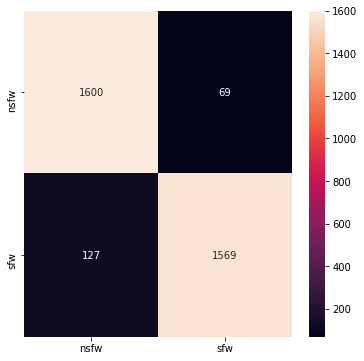

In [ ]:
plt.figure(figsize=(6,6))
sns.heatmap(df, annot=True, annot_kws={"size": 10},fmt="d")